# Tutorial: Rational Approximation of Golden Angle Sampling in BART


    Author:        Nick Scholand
    Email:         scholand@tugraz.at
    Institutions:  Graz University of Technology, Graz, Austria
                   NYU School of Medicine, New York, USA
		
Raw data, which has been acquired with the Rational Approximation of Golden Angles (RAGA) Sampling, can universally be converted into three different data formats:

* Full Frame (`FF`) Format
* Time-Resolved Retrospectively Binned Zero-Filled Full Frames (`TFF`) Format
* Time-Resolved Retrospectively Binned Compressed (`TC`) Format

allowing for reconstructing static or dynamic data without any additional information about the projection angle.
The raw data includes all this information directly.

Nevertheless, when being transformed in [BART](https://github.com/mrirecon/bart)'s default `FF` format, additional information is required to transform it into the `TFF` and `TC` format for time-resolved reconstructions.

This tutorial provides guidance of how to transform data into the individual formats and gives some examples of how to reconstruct them.

**About the Tutorial**  
The tutorial can run on the CPU only, but it is highly recommended to have a GPU. The examples have been optimized for the Google Colab service providing the hardware infrastructure including a GPU. If you want to run the scripts on a CPU remove the `-g` flags from all `nufft`, `pics`, and `rtnlinv` commands.

## 1. Preparations

### Setup BART on Google Colab

The following section sets up BART on Google Colab. For a detailed explanation, see the tutorial about [**How to Run BART on Google Colaboratory**](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

Please skip this part and click [here](#main) if you want to run this notebook on your local machine with BART already installed.

If you want to use a GPU instance, please turn it on in Google Colab:

    Go to Edit → Notebook Settings
    Choose GPU from Hardware Accelerator drop-down menu


We check which GPU instance was assigned to this notebook.

In [1]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA."
    echo "No further actions are required."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

GPU Type:
Tesla T4
Current GPU supports default CUDA-11.
No further actions are required.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 535.104.05, 15360 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


We download the current master branch version of BART and install its dependencies.

In [3]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc wget md5sum &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

We compile BART with some settings for running it on the GPU on Google Colab.

In [4]:
%%bash

# BRANCH=master
BRANCH=79fd4a72ac76d591d6b52df61eccaa8deae20f49 # Commit introducing zero-pad reordering

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

We set the required environment variables for BART.

In [2]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['BART_TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python")

We check the installed BART version.

In [5]:
%%bash

echo "# BART version: "
bart version

# BART version: 
v0.9.00-417-g79fd4a7


<a name='main'></a>
### Functions for Visualization

We define a function for visualization of the results.

In [6]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_data(file):
	# Import data using BART's python wrapper
	return np.abs(cfl.readcfl(file).squeeze())

def plot_data(data, vmax=-1, cmap='gray', title="", figsize=[6.4, 4.8], cbar_vis=False):

	fig = plt.figure(figsize=figsize)
	ax1 = fig.add_subplot(111)

	if (-1 == vmax): # Default: normalization
		im = ax1.imshow(data/np.max(data), cmap=cmap, vmin=0)
	else:
		im = ax1.imshow(data, cmap=cmap, vmin=0, vmax=vmax)

	ax1.set_yticklabels([])
	ax1.set_xticklabels([])
	ax1.xaxis.set_ticks_position('none')
	ax1.yaxis.set_ticks_position('none')

	divider = make_axes_locatable(ax1)
	cax = divider.append_axes("right", size="5%", pad=0.05)
	cbar = plt.colorbar(im, cax=cax)
	cbar.ax.tick_params(labelsize=15)
	cax.set_visible(cbar_vis)

	ax1.set_title(title)

def plot(reco, vmax=-1, cmap='gray', title="", figsize=[6.4, 4.8], cbar_vis=False):

	data = load_data(reco)

	data = np.flip(data, axis=0).T # Change orientation of object for visualization

	plot_data(data, vmax=vmax, cmap=cmap, title=title, figsize=figsize, cbar_vis=cbar_vis)


<a name='tutorials'></a>
### Previous Tutorials

This tutorial assumes basic knowledge about the cmdline tools of BART. Please check out the following tutorials to get some intuition about its handling.
- Introduction to BART Cmdline tools: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2019)
- Simulation tool in BART: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2022)
- Reconstructions by Nonlinear Inversion of the Bloch Equations in BART: [Link to Tutorial](https://github.com/mrirecon/bloch-tutorial)


### Download Dataset

This tutorial is based on a phantom dataset that has been provided for the publication:

<a name='paper'></a>
> #### Rational Approximation of Golden Angles: Accelerated Reconstructions for Radial MRI
> N. Scholand, P. Schaten, C. Graf, D. Mackner, H.C.M. Holme, M. Blumenthal, A. Mao, J. Assländer, and M. Uecker
>
> Submitted to Magnetic Resonance in Medicine
>
> [Preprint on ArXiv (DOI: 10.48550/arXiv.2401.02892)](https://doi.org/10.48550/arXiv.2401.02892)

The dataset was uploaded to [Zenodo, doi:10.5281/zenodo.10260250](https://doi.org/10.5281/zenodo.10260250) and is downloaded in the next cell.

In [22]:
%%bash

ZENODO_RECORD=12728657
DATASET=data_bin_raga

[ ! -f "${DATASET}.cfl" ] && wget -q https://zenodo.org/record/${ZENODO_RECORD}/files/${DATASET}.cfl
[ ! -f "${DATASET}.hdr" ] && wget -q https://zenodo.org/record/${ZENODO_RECORD}/files/${DATASET}.hdr


# Verify that the downloaded dataset is the expected one
[ ! -f "md5sum.txt" ] && wget -q https://github.com/mrirecon/raga-tutorial/-/blob/master/md5sum.txt

if md5sum --status -c md5sum.txt;
then
	echo "Downloaded files are correct."
else
	echo "Files are not matching their expected checksums!" 1>&2
	exit 1
fi

echo "All data has been downloaded successfully."


Downloaded files are correct.
All data has been downloaded successfully.


The dimensions of the dataset are:

In [23]:
%%bash
# Print the dimensions of the downloaded dataset
cat data_bin_raga.hdr

# Dimensions
1 400 377 18 1 1 1 1 1 1 10 1 1 1 1 1 


From the fact that radial data, which has been acquired on Siemens scanner, includes a two-fold oversampling in readout direction the dimensions provide the information about the base resolution of 200.
Per default RAGA sampled data in BART is stored in an equidistant angular pattern in a full frame `FF`, because it is self-explanatory and can easily be rearranged in both other data formats (`TFF` and `TC`).

The dimensions of the file provide the additional information that a full frame in this acquisition consisted of 377 spokes that have been acquired with 18 coils over 10 repetitions.

To reduce the computational complexity of this tutorial the first repetition is extracted from the dataset. All following scripts either support multiple repetitions already or can easily be generalized to incorporate them.

In [24]:
%%bash
# Extract first full frame of original dataset too reduce the computational complexity of the tutorial
bart slice 10 0 data_bin_raga ksp

cat ksp.hdr

# Dimensions
1 400 377 18 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
slice 10 0 data_bin_raga ksp 
# Files
 >ksp <data_bin_raga
# Creator
BART v0.9.00-417-g79fd4a7


<a name='ff'></a>
## 2. Full Frame Data Format

<a name='figure_1'></a>
<!-- <img src=figures/figure_FF.png alt="Illustration of full frame data format" width="600"/></br> -->
![Illustration of full frame data format](figures/figure_FF.png)</br>
**Figure 1**: Illustration of full frame data format `FF`.


RAGA sampled data in BART is per default provided in the full frame format `FF` with an equidistant angular pattern visualized in the [Figure 1](#figure_1).
Similar to the [zero-filled full frame format](#TFF), this enables us to reconstruct the data without any additional knowledge.
Everything required is solely defined by the dimension of the dataset.

Therefore, we can create a simple equidistant angular trajectory based on the dimensions.

In [25]:
%%bash

# Read required information about the equidistant angular pattern from dimensions of the data
SAMPLES=$(bart show -d 1 ksp)
SPOKES=$(bart show -d 2 ksp)

# Set the known oversampling factor (without you would have a distorted recon)
OVERSAMPLING=2
BASERES=$((SAMPLES/OVERSAMPLING))

# Generate the trajectory
bart traj -x ${BASERES} -y ${SPOKES} -o ${OVERSAMPLING} -r -D traj

# Print the dimensions of the created trajectory
cat traj.hdr

# Dimensions
3 400 377 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
traj -x 200 -y 377 -o 2 -r -D traj 
# Files
 >traj
# Creator
BART v0.9.00-417-g79fd4a7


This first dataset has 377 spokes and individual projection angles per full frame.
Following the base resolution of 200 the Nyquist limit is: $200\cdot\frac{\pi}{2}\approx 315$.  
Therefore, the data is fully-sampled and a simple PI reconstruction with BART's `pics` tool is sufficient for this example.


In [26]:
%%bash

# Coil Estimation
## Grid Data
bart nufft -g -a traj ksp bp
bart fft $(bart bitmask 0 1) bp ksp_grid
## Use ESPIRiT for coil estimation
bart ecalib -m 1 ksp_grid sens

# PI reconstruction
bart pics -g -t traj ksp sens reco_FF

Est. image size: 200x200x1
GPU reconstruction
[  1 400 377  18   1   1   1   1   1   1   1   1   1   1   1   1 ]
[200 200   1  18   1   1   1   1   1   1   1   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 3.784395


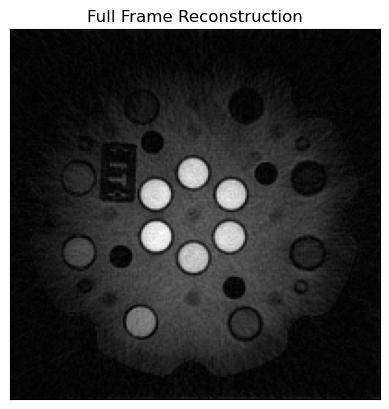

In [27]:
# Visualize the resulting reconstruction
plot("reco_FF", title="Full Frame Reconstruction")

The data has been acquired with an inversion-recovery FLASH sequence.
The signal of the first spokes follows an inversion recovery.
By reconstructing these spokes in a single full frame all different contrasts are mixed leading to the above image contrast.

To better understand the signal evolution more time steps during the inversion can be reconstructed providing a higher temporal resolution.
This can be done with the time-resolved data formats that are supported by RAGA sampling.

## 3. Time-Resolved Data Format

<a name='TFF'></a>
### 3.1 Zero-Filled Full Frames Format

<a name='figure_2'></a>
<!-- <img src=figures/figure_TFF.png alt="Illustration of time-resolved zero-padded full frame data format" width="600"/></br> -->
![Illustration of time-resolved zero-padded full frame data format](figures/figure_TFF.png)</br>
**Figure 2**: Illustration of time-resolved zero-padded full frame data format `TFF`.

In contrast to golden ratio sampling, RAGA supports two time-resolved data formats:

* Time-Resolved Retrospectively Binned Zero-Filled Full Frames (`TFF`)
* Time-Resolved Retrospectively Binned Compressed Data (`TC`)

While the `TC` format requires information about the projection angle to be reconstructed, `TFF`, illustrated in [Figure 2](#figure_2), allows reconstructions without any additional information, but increases the memory footprint due to zero-filling.

While raw data can be saved in the `TFF` format without any additional information, after storing it in the `FF` format the approximated angle $2\psi^1$ or the RAGA increment is required to convert `FF` into `TFF`.

This feature is implemented in BART's `traj` tool and can be combined with a trajectory generation to reconstruct the `TC` data format.
The necessary flags are the base angle order `-s 1` the fact that a double golden ratio angle has been approximated `--double-base`.

In [28]:
%%bash

# Read required information about the equidistant angular pattern from dimensions of the data
SAMPLES=$(bart show -d 1 ksp)
SPOKES=$(bart show -d 2 ksp)

# Set the known oversampling factor (without you would have a distorted recon)
OVERSAMPLING=2
BASERES=$((SAMPLES/OVERSAMPLING))

NUM_GOLDEN_RATIO=1 # Approximated Angle from external documentation

# Generate index file and traj for later reconstruction of the TC data format
bart traj -x ${BASERES} -y ${SPOKES} -o ${OVERSAMPLING} -r -D -A -s ${NUM_GOLDEN_RATIO} --double-base --raga-index-file ind traj_t

# Print dimensions of index file
cat ind.hdr

Golden Ratio Index is set to:	1
# Dimensions
1 1 377 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
traj -x 200 -y 377 -o 2 -r -D -A -s 1 --double-base --raga-index-file ind traj_t 
# Files
 >traj_t >ind
# Creator
BART v0.9.00-417-g79fd4a7


Based on the index file the equidistant angular dataset can be rearranged into the `TFF` format that incorporates the temporal information.
This is implemented in BART's `bin` tool with its `--zero-fill ${DIM}:${FRAMES}` option.
In this example, the dataset is rearranged to provide multiple time frames in BART's time dimension `10`.
Also the number of frames has to be provided.

If the selected number of frames is not a divisor of the total number of spokes per full frame then the last frame does not have the same amount of spokes as the previous ones.
Internally, this mismatch is compensated for by additional zero-filling of the missing spokes.


In [29]:
%%bash

TIME_DIM=10
TIME_FRAMES=13

# Rearrange FF data to TFF data with $TIME_FRAMES in the $TIME_DIM dimension
bart bin --zero-fill ${TIME_DIM}:${TIME_FRAMES} ind ksp ksp_t_zf

# Print dimensions
cat ksp_t_zf.hdr

Zero-filled binning...


# Dimensions
1 400 377 18 1 1 1 1 1 1 13 1 1 1 1 1 
# Command
bin --zero-fill 10:13 ind ksp ksp_t_zf 
# Files
 >ksp_t_zf <ksp <ind
# Creator
BART v0.9.00-417-g79fd4a7


While the dimensions of the data in this tutorial show 377 spokes per frame, most of them contain only zero after the zero-filled rearranging into the `TFF` format.

By selecting 10 frames in the time dimension every frame contains  $\text{ceil}(377 / 13) = 29$ spokes.
The amount of data per frame is below the Nyquist limit of 315 spokes and therefore undersampled.
For a reconstruction we therefore exploit a reconstruction by nonlinear inversion with regularization in time (RT-NLINV).

Because the memory layout in this example is still a full frame which has been extended by zero-filling, the corresponding sampling pattern is still defined by the dimensions alone and is equidistant angular. For the reconstruction we therefore reuse the previously created trajectory `traj.{cfl,hdr}`.

In [30]:
%%bash

SAMPLES=$(bart show -d 1 ksp)
BASERES=$((SAMPLES/2))

GN_ITER=8 # Gauss-Newton iterations

# Flip time dim for better initialization of first inversion frames
bart flip $(bart bitmask 10) ksp_t_zf{,2}

bart nlinv --real-time -g -S -x $BASERES:$BASERES:1 -i ${GN_ITER} -t traj ksp_t_zf2 _reco_zf_nlinv sens

# Restore initial time order
bart flip $(bart bitmask 10) _reco_zf_nlinv reco_zf_nlinv
rm _reco_zf_nlinv.cfl _reco_zf_nlinv.hdr

# Extract 5 frames of timesteps for visualization of the motion states
bart extract 10 0 5 reco_zf_nlinv reco_zf_nlinv_c

# Reshape for visualization
bart reshape $(bart bitmask 0 10) $((BASERES*5)) 1 reco_zf_nlinv_c reco_zf_nlinv_reshape

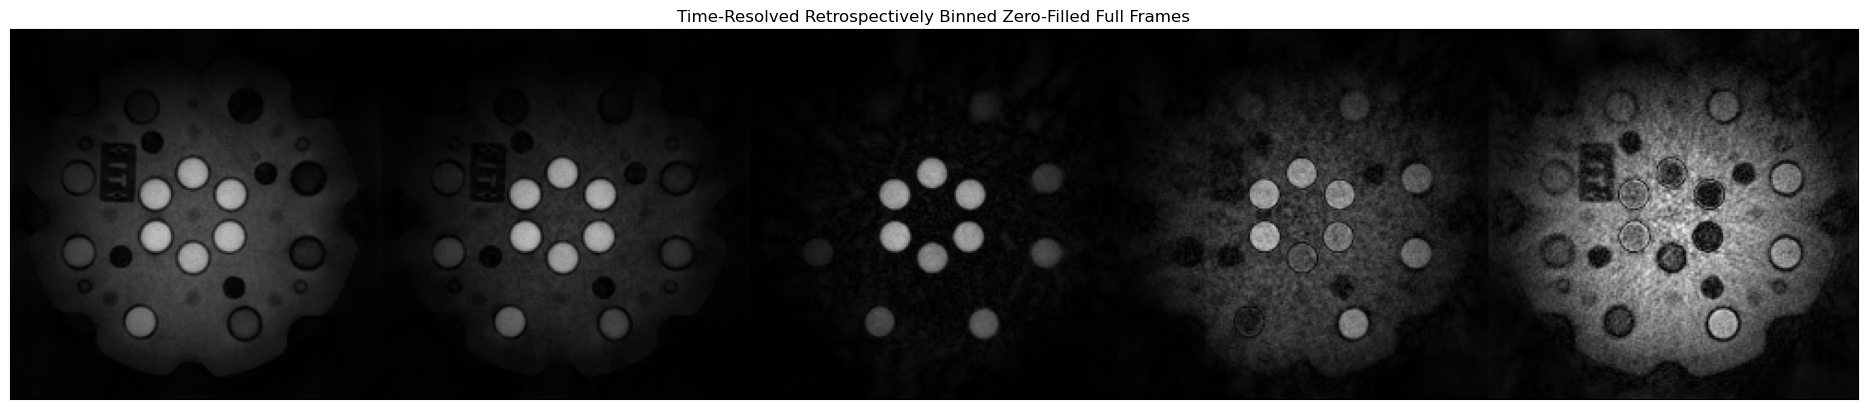

In [31]:
# Visualize the data
plot("reco_zf_nlinv_reshape", title="Time-Resolved Retrospectively Binned Zero-Filled Full Frames", figsize=[5*6.4,4.8])

Compared to the `FF` reconstruction the temporal resolution is increased to $2.9~\text{ms}\cdot 29\approx 84$ ms/frame and presents multiple states of the signal during the inversion.

<a name='TC'></a>
### 3.2 Compressed Format

<a name='figure_3'></a>
<!-- <img src=figures/figure_TC.png alt="Illustration of time-resolved compressed data format" width="600"/></br> -->
![Illustration of time-resolved compressed data format](figures/figure_TC.png)</br>
**Figure 3**: Illustration of time-resolved compressed data format `TC`.

After introducing the `FF` and `TFF` data format in section [2](#FF) and [3.1](#TFF) the third format is the Time-Resolved Retrospectively Binned Compressed Data (`TC`) illustrated in [Figure 3](#figure_3).
It is the only format golden ratio trajectories can support and requires precise information about the projection angle to be reconstructed accurately.

While RAGA raw data can again be universally saved in the `TC` format without any additional information, here we have to add knowledge about the approximated angle $2\psi^1$ or the RAGA increment again to convert `FF` into `TC`.
The corresponding index file for reordering the `FF` dataset in BART into `TC` is generated in the same way as demonstrated in the `TFF` data reconstruction.
The temporal trajectory `traj_t` is generated with the same call of BART's `traj` tool.

In [32]:
%%bash

# Read required information about the equidistant angular pattern from dimensions of the data
SAMPLES=$(bart show -d 1 ksp)
SPOKES=$(bart show -d 2 ksp)

# Set the known oversampling factor (without you would have a distorted recon)
OVERSAMPLING=2
BASERES=$((SAMPLES/OVERSAMPLING))

NUM_GOLDEN_RATIO=1 # Approximated Angle from external documentation

# Generate index file and traj for later reconstruction of the TC data format
bart traj -x ${BASERES} -y ${SPOKES} -o ${OVERSAMPLING} -r -D -A -s ${NUM_GOLDEN_RATIO} --double-base --raga-index-file ind traj_t

# Print dimensions of index file
cat ind.hdr

Golden Ratio Index is set to:	1
# Dimensions
1 1 377 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
traj -x 200 -y 377 -o 2 -r -D -A -s 1 --double-base --raga-index-file ind traj_t 
# Files
 >traj_t >ind
# Creator
BART v0.9.00-417-g79fd4a7


Because the `FF` data is only reordered into the `TC` format, `TC` provides the same memory footprint as the original `FF` dataset.

The reordering is performed with the `-o` flag of BART's `bin` tool.

In [33]:
%%bash

# Reorder equidistant data to temporal order without increasing the memory footprint
bart bin -o ind ksp ksp_t

# Print dimensions
cat ksp_t.hdr


Reorder binning...
# Dimensions
1 400 377 18 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
bin -o ind ksp ksp_t 
# Files
 >ksp_t <ksp <ind
# Creator
BART v0.9.00-417-g79fd4a7


Due to the temporal ordering of spokes in the `TC` format the `TC` data can not be reconstructed solely from knowing the dataset itself, but always require additional knowledge!

To achieve the same temporal resolution as in the previous `TFF` example, the data need to be rebinned.
Here, it is binned to 29 spokes per frame leading to the same temporal resolution of $2.9~\text{ms}=84.1$ ms.

In [34]:
%%bash

# Extract required dimensions from data
SPOKES=$(bart show -d 2 ksp_t)
TIME=$(bart show -d 10 ksp_t)

# Set temporal resolution to 2.9 ms * 29 = 84.1 ms
SPOKES_REBIN=29
TIME_REBIN=$(($((SPOKES*TIME))/SPOKES_REBIN))

# In case the number of spokes `SPOKES_REBIN` is not a divisor of the original spokes
# crop to closes smaller number of spokes
bart reshape $(bart bitmask 2 10) 1 $((SPOKES*TIME)) traj_t tmp
bart extract 10 0 $((TIME_REBIN*SPOKES_REBIN)) tmp t_crop
rm tmp.cfl tmp.hdr

bart reshape $(bart bitmask 2 10) 1 $((SPOKES*TIME)) ksp_t tmp
bart extract 10 0 $((TIME_REBIN*SPOKES_REBIN)) tmp k_crop
rm tmp.cfl tmp.hdr

# Reshape trajectory and data to new temporal resolution
bart reshape $(bart bitmask 2 10) $SPOKES_REBIN $TIME_REBIN t_crop traj_t_bin
rm t_crop.cfl t_crop.hdr

bart reshape $(bart bitmask 2 10) $SPOKES_REBIN $TIME_REBIN k_crop ksp_t_bin
rm k_crop.cfl k_crop.hdr

# Print dimensions of new trajectory and data
echo "Dimensions of trajectory"
cat traj_t_bin.hdr

echo "Dimensions of data"
cat ksp_t_bin.hdr

Dimensions of trajectory
# Dimensions
3 400 29 1 1 1 1 1 1 1 13 1 1 1 1 1 
# Command
reshape 1028 29 13 t_crop traj_t_bin 
# Files
 >traj_t_bin <t_crop
# Creator
BART v0.9.00-417-g79fd4a7
Dimensions of data
# Dimensions
1 400 29 18 1 1 1 1 1 1 13 1 1 1 1 1 
# Command
reshape 1028 29 13 k_crop ksp_t_bin 
# Files
 >ksp_t_bin <k_crop
# Creator
BART v0.9.00-417-g79fd4a7


Again the data is reconstructed with an RT-NLINV reconstruction compensating some of the missing infomration due to the undersampling.

In [35]:
%%bash

SAMPLES=$(bart show -d 1 ksp)
BASERES=$((SAMPLES/2))

GN_ITER=8 # Gauss-Newton iterations

# Flip time dim for better initialization of first inversion frames
bart flip $(bart bitmask 10) traj_t_bin{,2}
bart flip $(bart bitmask 10) ksp_t_bin{,2}

bart nlinv --real-time -g -S -x $BASERES:$BASERES:1 -i ${GN_ITER} -t traj_t_bin2 ksp_t_bin2 _reco_nlinv sens

# Restore initial time order
bart flip $(bart bitmask 10) _reco_nlinv reco_nlinv
rm _reco_nlinv.cfl _reco_nlinv.hdr

# Extract 5 frames of timesteps for visualization of the inversion states
bart extract 10 0 5 reco_nlinv reco_nlinv_c

# Reshape for visualization
bart reshape $(bart bitmask 0 10) $((BASERES*5)) 1 reco_nlinv_c reco_nlinv_reshape

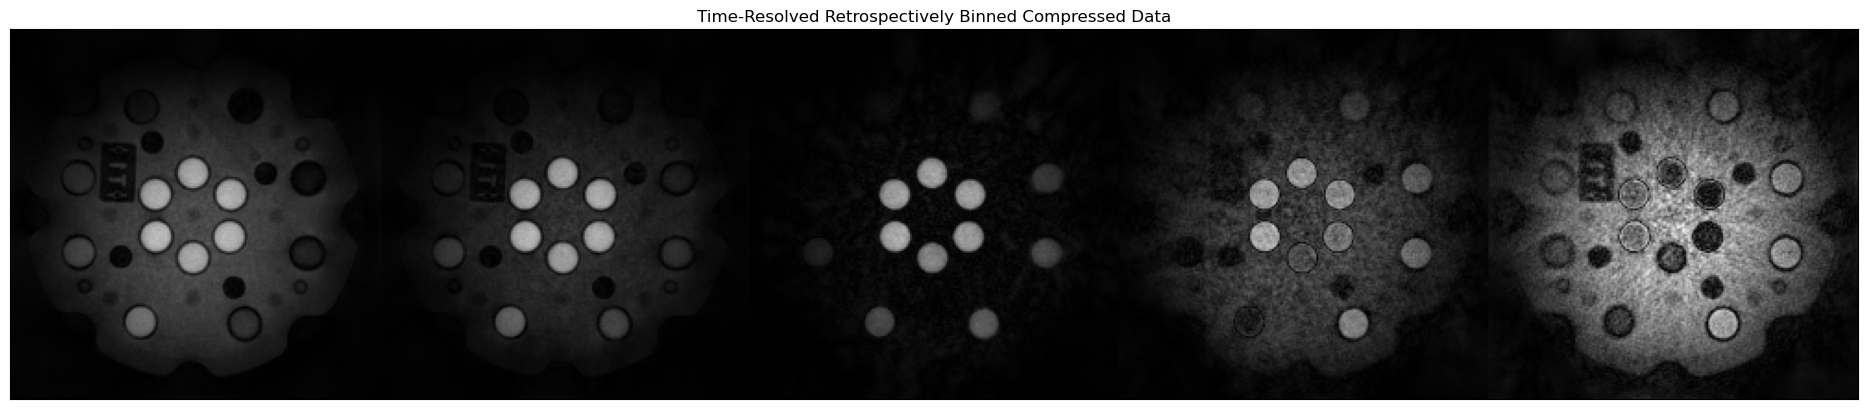

In [36]:
# Visualize the data
plot("reco_nlinv_reshape", title="Time-Resolved Retrospectively Binned Compressed Data", figsize=[5*6.4,4.8])

The reconstructions shows a high temporal resolution and can resolve the inversion states of the signal.

This concludes this introduction into the three different data formats RAGA data can be converted into.
If you want to learn more about the advantages and characteristics of RAGA sampling and how they compare to conventional golden ratio sampling we refer to publication references in the [preparation](#paper).

In [39]:
%%bash
# Clean up workspace
rm *.hdr *.cfl